In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset test

In [ ]:
from PrimeCNNv3.imports import *
from PrimeCNNv3.utils.data.dataset import *
from PrimeCNNv3.learner import *
from PrimeCNNv3.utils.vizualize import show_image

In [ ]:
#hide



SEED = 0

np.random.seed(SEED)
random.seed(SEED)

train_filepath = Path('../../../CovidX/CovidXv5-256px/train_COVIDx5.txt')
test_filepath = Path('../../../CovidX/CovidXv5-256px/test_COVIDx5.txt')

with open(train_filepath,'r') as file:
    cxr_list = np.array([line.rstrip('\n') for line in file])



In [ ]:
1e4

10000.0

In [ ]:
train_data = get_dataset(train_filepath, seed=0)

In [ ]:
#hide
train_lst, valid_lst = get_train_val_split(train_data, valid_pct=0.2, seed = 0)

In [ ]:
#hide
#stats

train_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
valid_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}

#for train ds
for element in train_lst:
    pathlogy = element.split()[-2]
    train_count[pathlogy] += 1

#for valid ds
for element in valid_lst:
    pathlogy = element.split()[-2]
    valid_count[pathlogy] += 1

In [ ]:
#hide
print(train_count)
print(valid_count)

{'normal': 6427, 'pneumonia': 4332, 'COVID-19': 408}
{'normal': 1539, 'pneumonia': 1143, 'COVID-19': 109}


In [ ]:
len(train_data)

13958

In [ ]:
train_ds = CovidXDataset(Path('../../../CovidX/CovidXv5-256px/train'), train_lst, seed = 0, dtype = 'uint8', )
valid_ds = CovidXDataset(Path('../../../CovidX/CovidXv5-256px/train'), valid_lst, seed = 0)

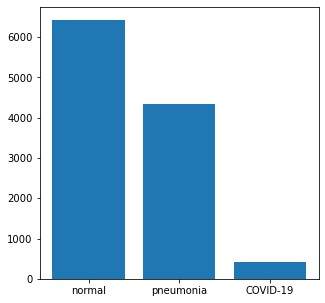

In [ ]:
train_ds.show_distribution()

# Using WeightedRandomSampler for ROS aand RUS

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 64, sampler = train_ds.get_Weighted_RandomSampler(use_generator=False))

In [ ]:
random_seed(203444066)
class_distrib = {0:0, 1:0, 2:0}
for xb, yb in train_dl:
    class_distrib[0] += len(yb[yb == 0])
    class_distrib[1] += len(yb[yb == 1])
    class_distrib[2] += len(yb[yb == 2])  
    

KeyboardInterrupt: 

In [ ]:
_, ax = plt.subplots(1,1, figsize = (5,5))
ax.bar(['Normal','Pneumonia', 'Covid-19'], class_distrib.values())

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print( 'target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

weight

#samples_weight = torch.from_numpy(samples_weight)
#samples_weigth = samples_weight.double()
#sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

#target = torch.from_numpy(target).long()
#train_dataset = torch.utils.data.TensorDataset(data, target)

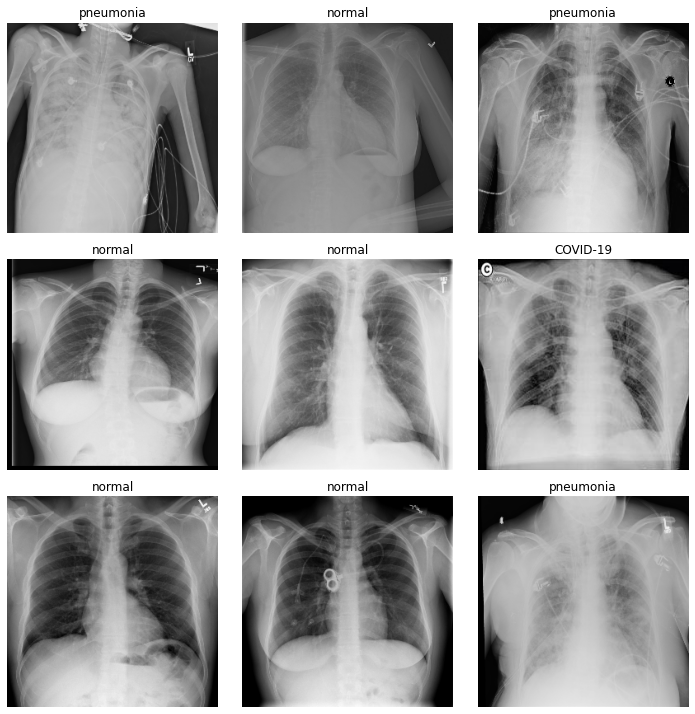

In [ ]:
train_ds.show_images(10, nrows=3, rand=True)

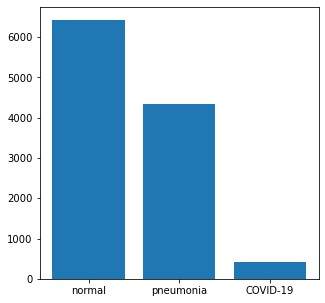

In [ ]:
train_ds.show_distribution()

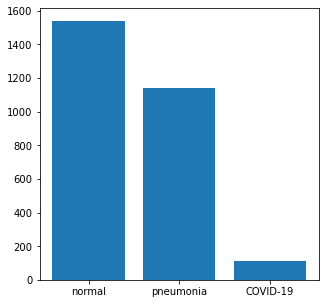

In [ ]:
valid_ds.show_distribution()

In [ ]:
def train_transform():
    return A.Compose([
       #A.Resize(324,324),\
        #A.RandomResizedCrop(324,324),
        A.RandomResizedCrop(256,256, scale = (0.6,1.0)),
        #A.RandomSizedCrop([215,215],256,256, p = 1.0),
        #A.CLAHE(p=1.0),
        #A.RandomGamma(p=1.0, always_apply=True)
        A.ShiftScaleRotate(p = 1.0),
       # A.HorizontalFlip(),    
        #A.VerticalFlip(),
       # A.RandomContrast(limit = .3),
       A.RandomBrightnessContrast(p=1.),
       # A.Normalize(),
        #ToTensorV2()
        ])
transform = train_transform()

In [ ]:
image, label = train_ds[222]

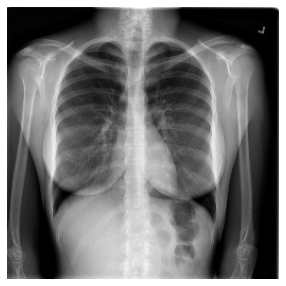

In [ ]:
show_image(image = image/255.0)
random_seed(42)

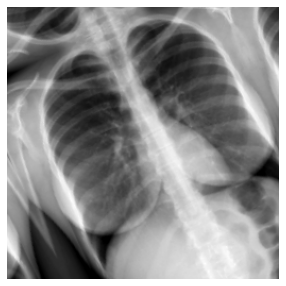

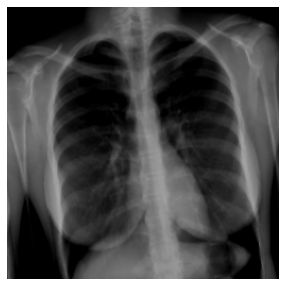

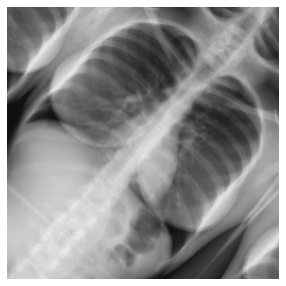

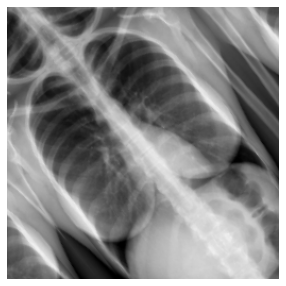

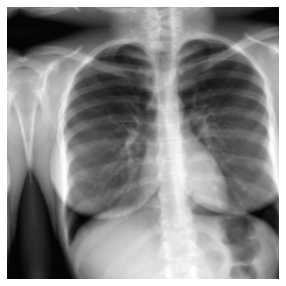

In [ ]:
for i in range(5):
    show_image(image = transform(image = image)['image'])

In [ ]:
label

0

# Learner test

In [ ]:
#hide
import os
from torchvision import datasets, models, transforms
from PrimeCNNv3.utils.data.dataloaders import DataLoaders
from PrimeCNNv3.utils.data.dataset import Dataset
from PrimeCNNv3.callbacks import *
from PrimeCNNv3.metric import *
from PrimeCNNv3.learner import *
from PrimeCNNv3.hooks import ForwardHook

In [ ]:
torch.randn((1,1))

tensor([[1.5410]])

In [ ]:
torch.initial_seed() % 2**32

0

In [ ]:
np.random.randint(2147483647)

209652396

In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d,self).__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [ ]:
random_seed(0)
head = nn.Sequential(
                     nn.Flatten(),
                     nn.BatchNorm1d(num_features=1024,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.Dropout(p = 0.25, inplace = False),
                     nn.Linear(in_features=1024, out_features=512, bias= False),
                     nn.ReLU(inplace=True),
                     nn.BatchNorm1d(num_features=512,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.Dropout(p = 0.5, inplace = False),
                     nn.Linear(in_features=512, out_features=10, bias= False)
                     
)

In [ ]:
#hide
random_seed(0)
model = models.resnet34(pretrained = True)
model.avgpool = nn.Sequential(AdaptiveConcatPool2d())
model.fc = head

transform = transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225))])

dataset1 = datasets.ImageFolder(root=Path('data/imagenette-320/train/'),transform=transform)
testset = datasets.ImageFolder(root=Path('data/imagenette-320/val/'), transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,batch_size = 32,shuffle = True, pin_memory = True)
                                       
valid_loader = torch.utils.data.DataLoader(testset, batch_size = 32,shuffle = True, pin_memory = True)
dls = DataLoaders(train_loader, valid_loader, device='cuda') 


In [ ]:
#pso = PSO_iter_v1(population=5)

cbs = [SetupLearnerCB(),Recorder(),ShowStats()]

learn = Learner(model,dls, metric = [accuracy, precision, recall, f1score], 
                cbs = cbs,loss_func=nn.CrossEntropyLoss(), 
                opt_func=torch.optim.AdamW )

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Loss exploding.. stopping training
Suggested LR : 
min_lr: 0.04328761398792267 
lr_steep: 0.0018738174112513661


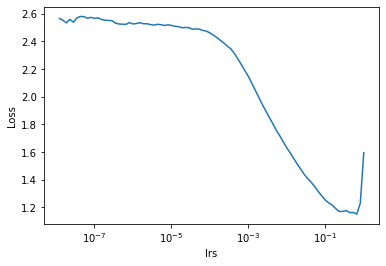

In [ ]:
#hide
random_seed(0)
learn.freeze_to(-2)
learn.lr_finder(wd=1e-04)

In [ ]:
import torch.multiprocessing as mp

num_process = 4

processes = []
learner_ = []
for rank in range(num_process):
    cbs = [SetupLearnerCB(),Recorder(),ShowStats()]
    learn = Learner(get_model(),dls, metric = [accuracy, precision, recall, f1score], 
                cbs = cbs,loss_func=nn.CrossEntropyLoss(), 
                opt_func=torch.optim.AdamW )
    learn.freeze_to(-2)
    learner_.append(learn)
    print(f'starting Process: {rank}')
    p = mp.Process(target= learn.fit, args=(1,1e-03/(rank+1),1e-04/(rank+1)))
    print(f'Entering Process: {rank}')
    p.start()
    print(f'Started Process: {rank}')
    processes.append(p)
    
for p in processes:
    p.join()
    

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze
starting Process: 0
Entering Process: 0


Initializing PSO
Selected particle 1
Particle 1 Added to the Swarm
Selected particle 2
Loss exploding.. stopping training
Particle 2 Added to the Swarm
Selected particle 3
Particle 3 Added to the Swarm
Selected particle 4
Particle 4 Added to the Swarm
Selected particle 5
Particle 5 Added to the Swarm
Best solution after initialization: 0.41784453135400634


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,865059.219853,1.381719,0.59,0.662562,0.59,0.578733,03:52
1,34.21953,2.958353,0.108,0.026127,0.108,0.033714,04:45
2,1465177.742694,362137.0355,0.102,0.039689,0.102,0.029833,04:41
3,1890.397198,579.782094,0.134,0.094969,0.134,0.063569,03:57
4,298.735432,20.044282,0.1,0.01,0.1,0.018182,03:58


Selected particle 1
Loss exploding.. stopping training
Selected particle 1 fitness : 0.44434065934065936
Selected particle 2
Loss exploding.. stopping training
Selected particle 2 fitness : 0.3395929339477727
Selected particle 3
Loss exploding.. stopping training
Selected particle 3 fitness : 0.4743378843378844
Selected particle 4
Loss exploding.. stopping training
Selected particle 4 fitness : 0.39172119869794286
Selected particle 5
Loss exploding.. stopping training
Selected particle 5 fitness : 0.3580065965780251
Best Solution fitness: 0.4743378843378844


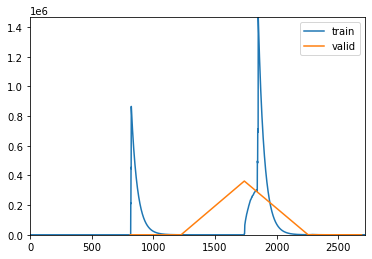

Selected particle 1
Loss exploding.. stopping training
Selected particle 1 fitness : 0.07175822941242557
Selected particle 2
Selected particle 2 fitness : 0.03415046045900729
Selected particle 3
Loss exploding.. stopping training
Selected particle 3 fitness : 0.045598086124401915
Selected particle 4
Loss exploding.. stopping training
Selected particle 4 fitness : 0.0661764705882353
Selected particle 5
Loss exploding.. stopping training
Selected particle 5 fitness : 0.054298642533936646
Best Solution fitness: 0.4743378843378844


c:\program files\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected particle 1
Loss exploding.. stopping training
Selected particle 1 fitness : 0.03365079365079365
Selected particle 2
Selected particle 2 fitness : 0.023105142991840518
Selected particle 3
Loss exploding.. stopping training
Selected particle 3 fitness : 0.06645345425833231
Selected particle 4
Loss exploding.. stopping training
Selected particle 4 fitness : 0.05029304029304029
Selected particle 5
Loss exploding.. stopping training
Selected particle 5 fitness : 0.05289206917113894
Best Solution fitness: 0.4743378843378844
Selected particle 1
Loss exploding.. stopping training
Selected particle 1 fitness : 0.09616600407097224
Selected particle 2
Loss exploding.. stopping training
Selected particle 2 fitness : 0.06035095948489081
Selected particle 3
Loss exploding.. stopping training
Selected particle 3 fitness : 0.07103938444844508
Selected particle 4
Loss exploding.. stopping training
Selected particle 4 fitness : 0.07430832708177044
Selected particle 5
Loss exploding.. stopping t

In [ ]:
random_seed(0)
learn.fit(5,lr=6e-04,wd = 1e-04)

In [ ]:
1e-03

In [ ]:
preds, target = learn.get_preds(valid_loader)

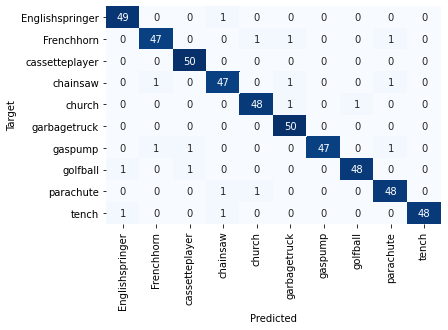

In [ ]:
classes = dataset1.classes
plot_confusion_matrix(preds = preds, target=target, labels=classes)

In [ ]:
learn.save_model(Path('model.pth'))

In [ ]:
learn.load_model(Path('model.pth'))

# Class Activation Map (CAM)

In [ ]:
image_, label = testset[-100]

In [ ]:
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])

In [ ]:
image = image_.permute((1,2,0))
image = ((image * std) + mean)

In [ ]:
label

8

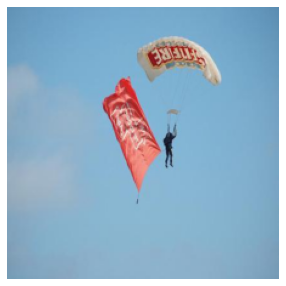

In [ ]:
show_image(image=np.array(image))

In [ ]:
with ForwardHooks(learn.model.layer4) as hook:
    with torch.no_grad():
        pred = learn.model.eval()(image_.unsqueeze(0).cuda())
        
    acts = hook.stored[0]

In [ ]:
from torchsummary import summary
summary(learn.model, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

In [ ]:
last_weight = learn.model.fc[-1].weight.detach().clone()

In [ ]:
last_weight.shape

torch.Size([10, 512])

In [ ]:
acts.shape

torch.Size([512, 7, 7])

In [ ]:
cam = torch.einsum('ck, kij->cij', last_weight,acts)
cam.shape

torch.Size([10, 7, 7])

index to cam must be the prediction/target class. This tells us what the model looked for predicting that particular class

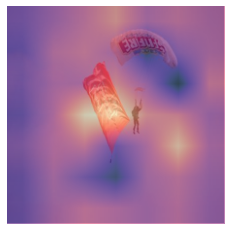

In [ ]:
_,ax = plt.subplots()
show_image(image = image, ax= ax)
ax.imshow(X = cam[8].detach().cpu(),alpha=0.6, extent=(0,224,224,0), interpolation='bilinear', cmap = 'magma')

cam[0].shape

In [ ]:
# Test Implementation of PSO

# Problem Definition

Implementation of PSO for opimizing the hyperparameter lr,wd,eps, bets

In [ ]:
import copy

In [ ]:
# set dim of the problem
Dim = 4

#define searchspace
DimMin = 6.10e-030
DimMax = 0.9999999999999999

In [ ]:
#PSO parameters
population = 5
max_iter = 10

c1 = 2
c2 = 2

In [ ]:
# define particle
class Particle:
    pass

In [ ]:
gbest = Particle()
gbest.fitness = float('inf')

# Idea 2, iteration wise using callback

In [ ]:
class Particle:
        pass

class PSO_iter_v1(Callbacks):
    # define particle
    
    
    def __init__(self,max_iter= 100, population = 50, c1= 2, c2 = 2, W = 0.76):
        self.Dim = 4
        self.maxx_iter = max_iter
        self.c1 = c1
        self.c2 = c2
        self.population = population
        self.gbest = Particle()
        self.gbest.fitness = float('-inf')
        self.lr_wd_limit = (1e-030,1e-01)
        self.betas_limit = (1e-030,9e-01)
        
    def _fitness(self,x):
        return 1 / (1 + x)
    
    def _save_model(self):
        saved_param = {
            'model' : self.model.state_dict(),
            'optimizer' : self.opt.state_dict() if self.opt is not None else None,
            'lr_schedular' : self.lr_schedular if self.lr_schedular is not None else None
        }
        
        torch.save(saved_param, 'tmp_model.pth')
    
    def _load_model(self):
        saved_param = torch.load('tmp_model.pth')
        self.model.load_state_dict(saved_param['model'])
        
        if saved_param['optimizer'] is None:
            self.opt = None
        else:
            self.opt.load_state_dict(saved_param['optimizer'])
        
        if saved_param['lr_schedular'] is None:
            self.lr_schedular = None
        else:
            self.lr_schedular = saved_param['lr_schedular']
        
    def __swarm_init(self):
        print('Initializing PSO')
        
        self.learner.training = True
        self._save_model()
        
        for idx in range(self.population):
            avg_loss = 0.
            beta = 0.9
            best_loss = 0.
            preds = []
            target = []
            
            print(f'Selected particle {str(idx+1)}')
            particle = Particle()
            
            #randomly initialize the particle position and velocity
            particle.position = np.concatenate((np.random.uniform(*self.lr_wd_limit, 2), np.random.uniform(*self.betas_limit, 2)))
            particle.velocity = np.concatenate((np.random.uniform(*self.lr_wd_limit, 2), np.random.uniform(*self.betas_limit, 2)))
            
            self.opt.param_groups[0]['lr'] = particle.position[0]
            self.opt.param_groups[0]['weight_decay'] = particle.position[1]
            self.opt.param_groups[0]['betas'] = (particle.position[2], particle.position[3])
            
            for idx_ in range(self.maxx_iter):
                self.learner.batch = iter(self.dls.train).next()
                
                '''Define model and initialize it for one epoch'''
            
                #run one iteration
            
                self.do_batch()
                
                preds.append(self.preds.cpu().detach())
                target.append(self.yb.cpu().detach())
                
                avg_loss = avg_loss * beta + (1-beta) * self.running_loss
                smooth_loss = avg_loss / (1 - beta**(idx_ + 1))
            
                if idx_ + 1 > 1 and smooth_loss > 4 * best_loss:
                    print('Loss exploding.. stopping training')
                    break
            
                if smooth_loss < best_loss or idx_ + 1 == 1:
                    best_loss = smooth_loss
                
            particle.fitness = f1score(preds = torch.cat(preds), target = torch.cat(target))
            
            #initialize pbest
            particle.pbest = particle.position
            particle.pbestFitness = particle.fitness
    
            #select gbest
            if self.gbest.fitness < particle.pbestFitness:
                self.gbest.fitness = particle.pbestFitness
                self.gbest.position = particle.pbest
        
            print(f'Particle {str(idx+1)} Added to the Swarm')
            self.Swarm.append(particle)
            self._load_model()
        print('Best solution after initialization: '+str(self.gbest.fitness))
        self.best_solution.append(self.gbest.fitness)
        self.init_flag = False
     
    def _run_pso(self):
        self.learner.training = True
        self._save_model()
        
        for idx in range(self.population):
            avg_loss = 0.
            beta = 0.9
            best_loss = 0.
            preds = []
            target = []
            print(f'Selected particle {str(idx+1)}')
            
            self.Swarm[idx].velocity = self.Swarm[idx].velocity + self.c1 * np.random.rand(self.Dim) * (self.Swarm[idx].pbest - self.Swarm[idx].position) + self.c2 * np.random.rand(self.Dim) * (self.gbest.position - self.Swarm[idx].position)

            self.Swarm[idx].position = self.Swarm[idx].position + self.Swarm[idx].velocity
            
            #check wheteher solution is within bounds
            self.Swarm[idx].position[:2] = np.maximum(self.Swarm[idx].position[:2], self.lr_wd_limit[0])
            self.Swarm[idx].position[:2] = np.minimum(self.Swarm[idx].position[:2], self.lr_wd_limit[1])
        
            self.Swarm[idx].position[2:] = np.maximum(self.Swarm[idx].position[2:], self.betas_limit[0])
            self.Swarm[idx].position[2:] = np.minimum(self.Swarm[idx].position[2:], self.betas_limit[1])
            
            self.opt.param_groups[0]['lr'] = self.Swarm[idx].position[0]
            self.opt.param_groups[0]['weight_decay'] = self.Swarm[idx].position[1]
            self.opt.param_groups[0]['betas'] = (self.Swarm[idx].position[2], self.Swarm[idx].position[3])
            
            for idx_ in range(self.maxx_iter):
                self.learner.batch = iter(self.dls.train).next()
                
                '''Define model and initialize it for one epoch'''
            
                #run one iteration
            
                self.do_batch()
                #fitness = f1score(preds = self.preds.cpu().detach(), target = self.yb.cpu().detach())
                
                preds.append(self.preds.cpu().detach())
                target.append(self.yb.cpu().detach())
                
                avg_loss = avg_loss * beta + (1-beta) * self.running_loss
                smooth_loss = avg_loss / (1 - beta**(idx_ + 1))
            
                if idx_ + 1 > 1 and smooth_loss > 4 * best_loss:
                    print('Loss exploding.. stopping training')
                    break
            
                if smooth_loss < best_loss or idx_ + 1 == 1:
                    best_loss = smooth_loss
            
            self.Swarm[idx].fitness = f1score(preds = torch.cat(preds), target = torch.cat(target))
            print(f'Selected particle {str(idx+1)} fitness : {self.Swarm[idx].fitness}')
            #update pbest
            if self.Swarm[idx].fitness > self.Swarm[idx].pbestFitness:
                self.Swarm[idx].pbestFitness = self.Swarm[idx].fitness
                self.Swarm[idx].pbest = self.Swarm[idx].position
            
            #update global best
            if self.Swarm[idx].pbestFitness > self.gbest.fitness:
                self.gbest.fitness = self.Swarm[idx].pbestFitness
                self.gbest.position = self.Swarm[idx].pbest
            
            self._load_model() 
            self.best_solution.append(self.gbest.fitness)
        
    def before_fit(self):
        self.init_flag = True
        self.Swarm = []
        self.best_solution = []
        self.__swarm_init()
    def before_train_epoch(self):
        self.opt.param_groups[0]['lr'] = self.gbest.position[0]
        self.opt.param_groups[0]['weight_decay'] = self.gbest.position[1]
        self.opt.param_groups[0]['betas'] = (self.gbest.position[2], self.gbest.position[3])

    def after_valid_epoch(self):
        self._run_pso()        
        print('Best Solution fitness: '+str(self.gbest.fitness))

In [ ]:
random_seed(42)
def get_model():
    model = models.resnet34(pretrained = True)
    model.avgpool = nn.Sequential(AdaptiveConcatPool2d())
    model.fc = head
    
    return model

cbs = [SetupLearnerCB(),Recorder(),ShowStats()]
learn = Learner(get_model(),dls, metric = [accuracy, precision, recall, f1score], 
                cbs = cbs,loss_func=nn.CrossEntropyLoss(), 
                opt_func=torch.optim.AdamW )

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,7.819982,971.736432,0.1,0.01,0.1,0.018182,03:41


c:\program files\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


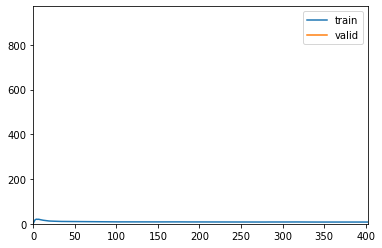

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,80.660446,66.739701,0.1,0.01,0.1,0.018182,03:37


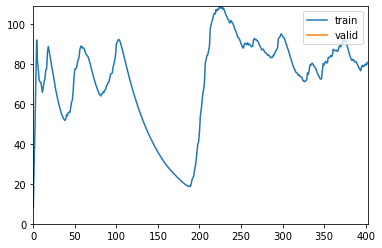

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,19.386008,23.05986,0.1,0.01,0.1,0.018182,03:41


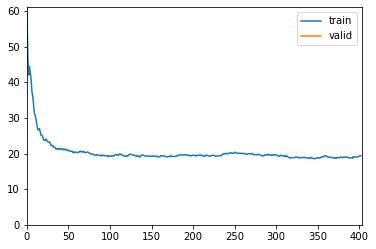

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,29.974461,20.900945,0.1,0.01,0.1,0.018182,03:38


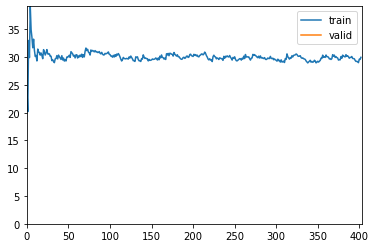

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.353785,2.361737,0.1,0.01,0.1,0.018182,03:41


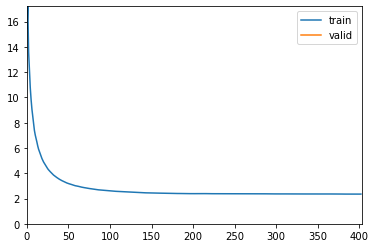

In [ ]:
#initialize the swarm population
Swarm = []

for individual in range(population):
    particle = Particle()
    
    particle.position = np.random.uniform(DimMin, DimMax, Dim)
    particle.velocity = np.random.uniform(DimMin, DimMax, Dim)
    
    '''Define model and initialize it for one epoch'''
    
    learn.model =  get_model()
    learn.freeze_to(-2)
    learn.fit(epochs = 1, lr = particle.position[0], wd = particle.position[1], betas = (particle.position[2], particle.position[3]))
    particle.model_weight = copy.deepcopy(learn.model.state_dict())
    #evalute the metric
    particle.fitness = learn.log[1]
    
    #initialize pbest
    particle.pbest = particle.position
    particle.pbestFitness = particle.fitness
    
    #select gbest
    if gbest.fitness > particle.pbestFitness:
        gbest.fitness = particle.pbestFitness
        gbest.position = particle.pbest
        
    Swarm.append(particle)

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.34439,2.39319,0.1,0.01,0.1,0.018182,03:38


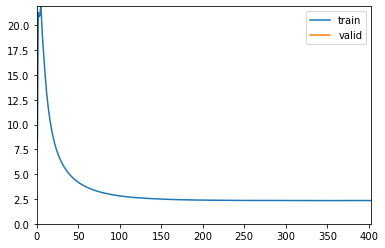

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.307518,2.30263,0.1,0.01,0.1,0.018182,03:34


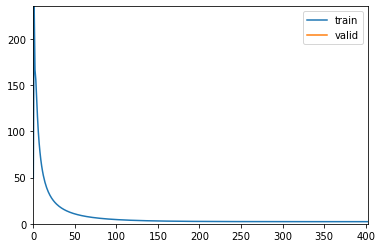

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.306311,2.302816,0.1,0.01,0.1,0.018182,03:36


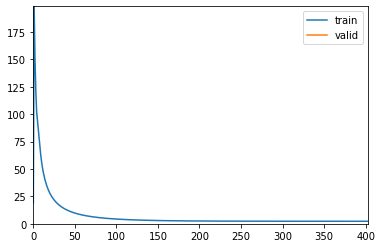

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.52993,2.415788,0.1,0.01,0.1,0.018182,03:36


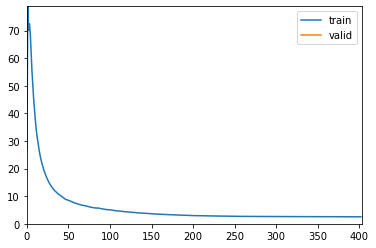

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305072,2.302701,0.1,0.01,0.1,0.018182,03:16


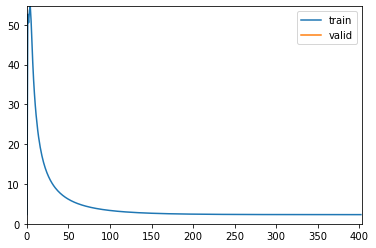

Best Solution: 2.305072
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.30437,2.302822,0.1,0.01,0.1,0.018182,03:15


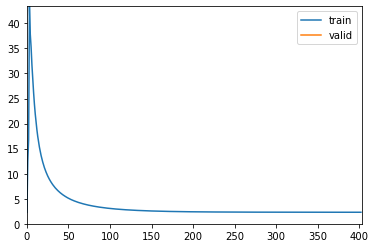

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304747,2.302694,0.1,0.01,0.1,0.018182,03:14


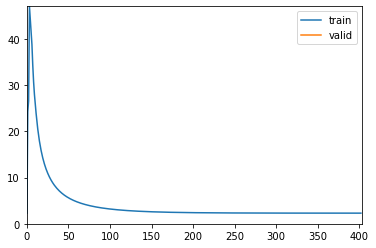

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304263,2.302873,0.1,0.01,0.1,0.018182,03:16


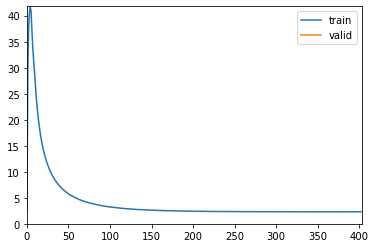

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305291,2.302665,0.1,0.01,0.1,0.018182,03:33


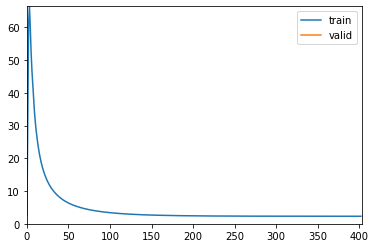

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305188,2.302684,0.1,0.01,0.1,0.018182,03:41


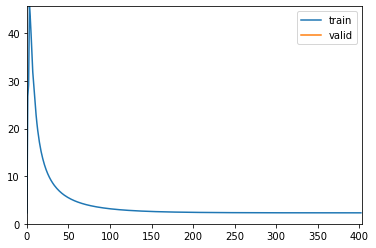

Best Solution: 2.304263
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304855,2.30289,0.1,0.01,0.1,0.018182,03:45


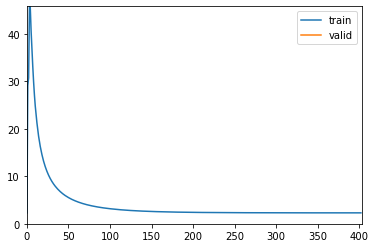

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304191,2.302868,0.1,0.01,0.1,0.018182,03:39


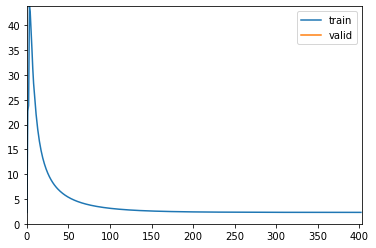

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305044,2.302677,0.1,0.01,0.1,0.018182,03:36


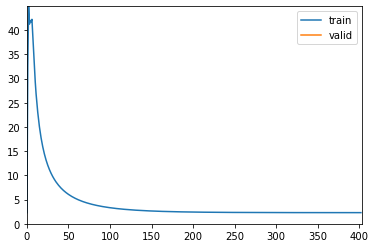

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304917,2.302646,0.1,0.01,0.1,0.018182,03:47


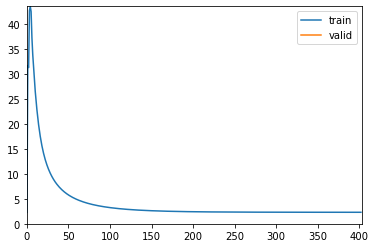

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304329,2.302775,0.1,0.01,0.1,0.018182,03:40


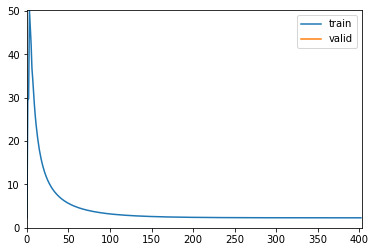

Best Solution: 2.304191
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304727,2.302826,0.1,0.01,0.1,0.018182,03:36


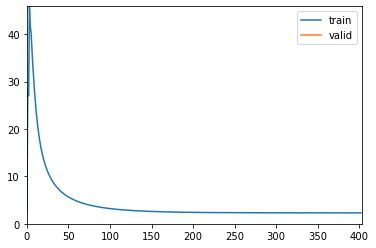

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.30466,2.302817,0.1,0.01,0.1,0.018182,03:40


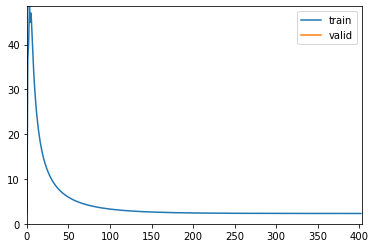

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304737,2.302677,0.1,0.01,0.1,0.018182,03:40


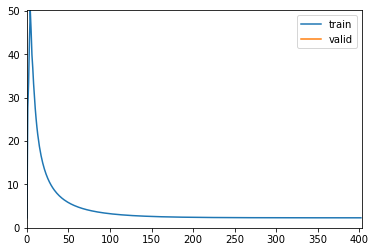

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304928,2.30276,0.1,0.01,0.1,0.018182,03:39


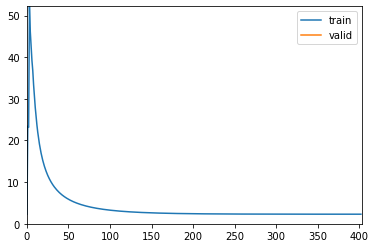

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.30507,2.302876,0.1,0.01,0.1,0.018182,03:37


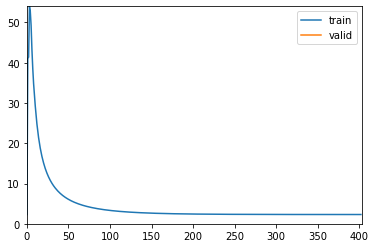

Best Solution: 2.304191
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304998,2.302802,0.1,0.01,0.1,0.018182,03:37


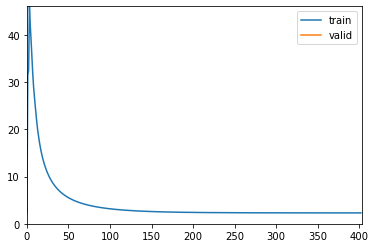

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305272,2.302652,0.1,0.01,0.1,0.018182,03:41


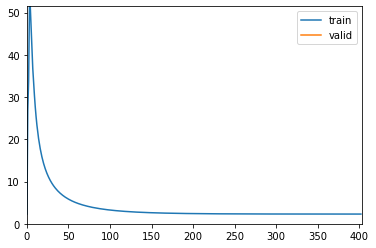

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.303931,2.302938,0.1,0.01,0.1,0.018182,03:37


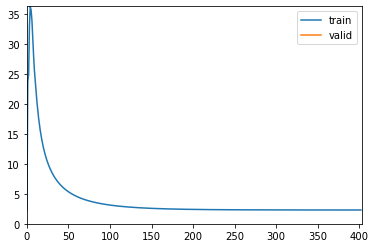

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304931,2.302675,0.1,0.01,0.1,0.018182,03:46


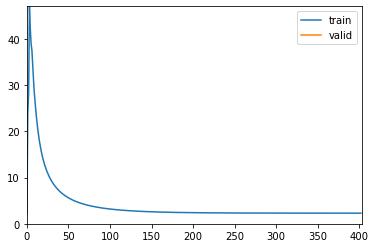

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304509,2.302973,0.1,0.01,0.1,0.018182,03:40


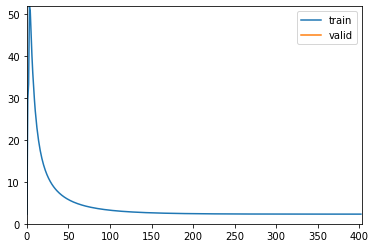

Best Solution: 2.303931
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304303,2.30292,0.1,0.01,0.1,0.018182,03:41


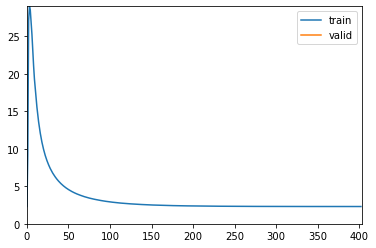

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305158,2.302637,0.1,0.01,0.1,0.018182,03:42


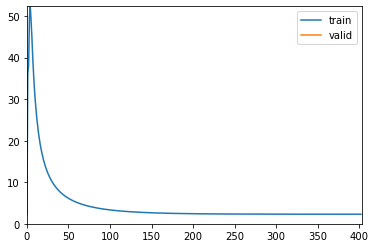

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304719,2.302734,0.1,0.01,0.1,0.018182,03:40


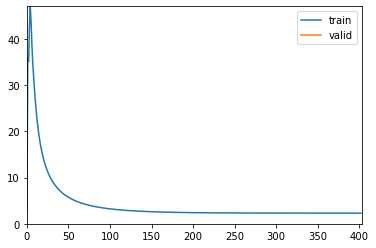

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304685,2.302836,0.1,0.01,0.1,0.018182,03:37


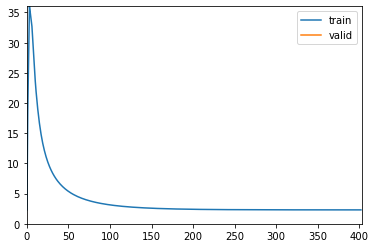

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304816,2.302957,0.1,0.01,0.1,0.018182,03:37


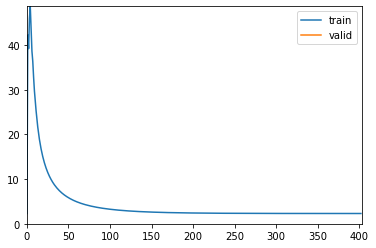

Best Solution: 2.303931
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305492,2.302698,0.1,0.01,0.1,0.018182,03:38


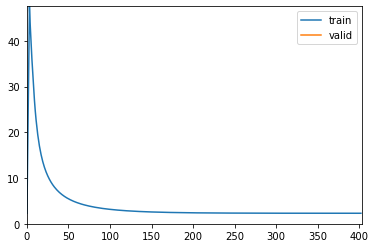

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304398,2.302756,0.1,0.01,0.1,0.018182,03:39


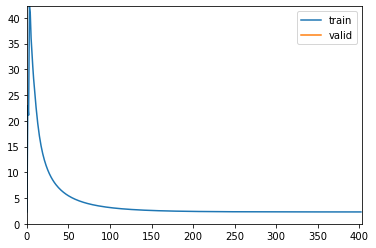

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305349,2.302675,0.1,0.01,0.1,0.018182,03:42


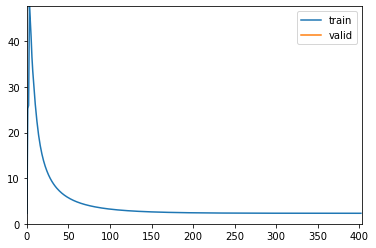

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304466,2.302778,0.1,0.01,0.1,0.018182,03:37


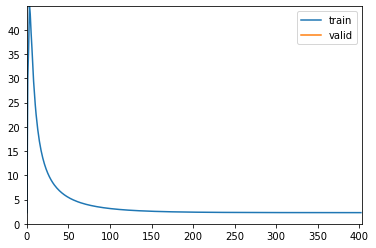

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304732,2.302734,0.1,0.01,0.1,0.018182,03:38


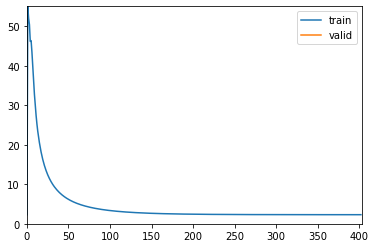

Best Solution: 2.303931
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304811,2.302739,0.1,0.01,0.1,0.018182,03:38


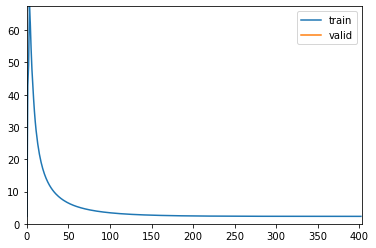

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304611,2.302763,0.1,0.01,0.1,0.018182,03:38


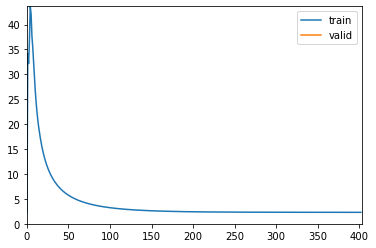

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305258,2.30271,0.1,0.01,0.1,0.018182,03:37


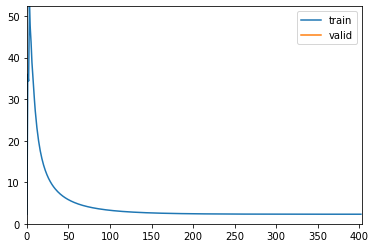

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304209,2.302857,0.1,0.01,0.1,0.018182,03:39


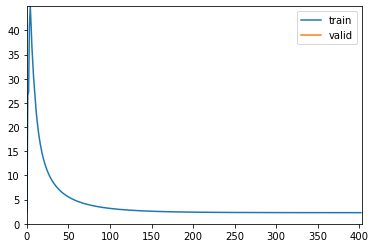

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304816,2.302674,0.1,0.01,0.1,0.018182,03:38


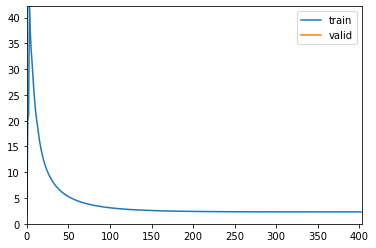

Best Solution: 2.303931
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305231,2.302695,0.1,0.01,0.1,0.018182,03:44


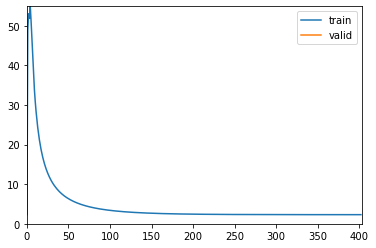

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305265,2.302704,0.1,0.01,0.1,0.018182,03:38


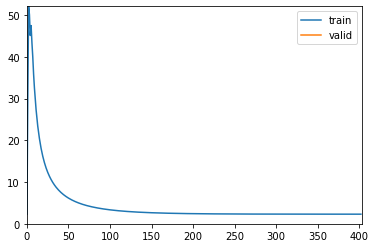

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304575,2.302822,0.1,0.01,0.1,0.018182,03:41


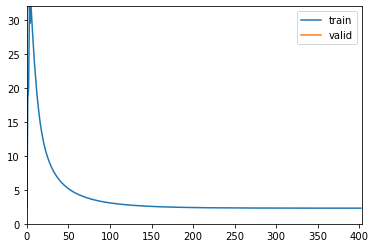

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.30514,2.302703,0.1,0.01,0.1,0.018182,03:38


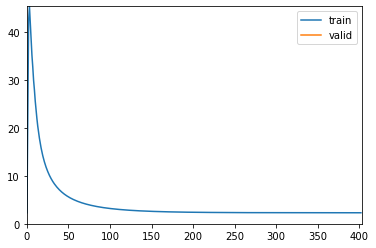

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304485,2.302871,0.1,0.01,0.1,0.018182,03:46


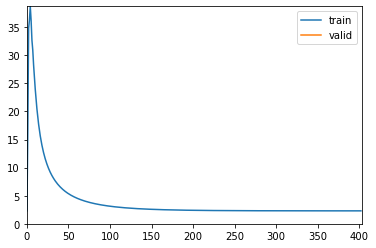

Best Solution: 2.303931
Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304575,2.302743,0.1,0.01,0.1,0.018182,03:41


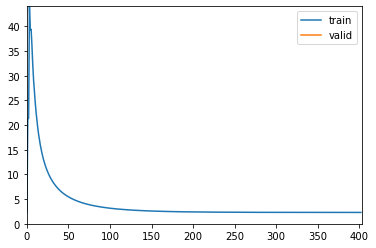

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.30433,2.302914,0.1,0.01,0.1,0.018182,03:41


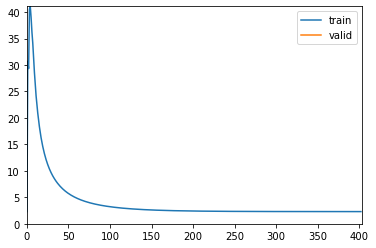

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304762,2.302874,0.1,0.01,0.1,0.018182,03:44


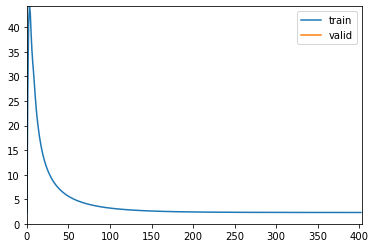

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.304565,2.302753,0.1,0.01,0.1,0.018182,03:38


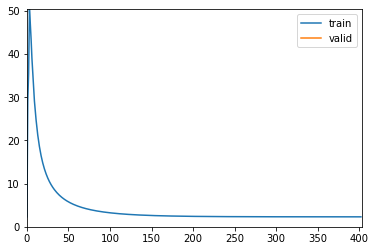

Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,2.305395,2.302798,0.1,0.01,0.1,0.018182,03:46


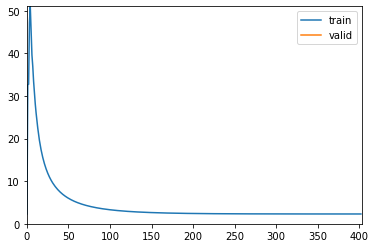

Best Solution: 2.303931


In [ ]:
for iteration in range(0,max_iter):
    for idx in range(0, len(Swarm)):
        
        #velocity update
        Swarm[idx].velocity = Swarm[idx].velocity + c1 * np.random.rand(Dim) * (Swarm[idx].pbest - Swarm[idx].position) + c2 * np.random.rand(Dim) * (gbest.position - Swarm[idx].position) 
        
        #position update
        Swarm[idx].position = Swarm[idx].position + Swarm[idx].velocity
        
        #new position within range i.e bound
        
        Swarm[idx].position = np.maximum(Swarm[idx].position, DimMin)
        Swarm[idx].position = np.minimum(Swarm[idx].position, DimMax)
        
        learn.model.load_state_dict(Swarm[idx].model_weight)
        
        learn.freeze_to(-2)
        learn.fit(epochs = 1, lr = Swarm[idx].position[0], wd = Swarm[idx].position[1], betas = (Swarm[idx].position[2], Swarm[idx].position[3]))
        Swarm[idx].model_weight = copy.deepcopy(learn.model.state_dict())
        
        #evalute the metric
        Swarm[idx].fitness = learn.log[1]
        
        #update personal best
        if Swarm[idx].fitness < Swarm[idx].pbestFitness:
            Swarm[idx].pbestFitness = Swarm[idx].fitness
            Swarm[idx].pbest = Swarm[idx].position
            
        #update global best
        if Swarm[idx].pbestFitness < gbest.fitness:
            gbest.fitness = Swarm[idx].pbestFitness
            gbest.position = Swarm[idx].pbest
            
    print('Best Solution: '+str(gbest.fitness))

In [ ]:
best_solution

NameError: name 'best_solution' is not defined

In [ ]:
lr_wd = np.random.uniform(1e-030,1e-01, 2)

In [ ]:
np.concatenate((np.random.uniform(1e-030,1e-01, 2), np.random.uniform(1e-030,1e-01, 2)))

array([0.0891773 , 0.09636628, 0.03834415, 0.0791725 ])

In [ ]:
opt.param_groups[0]['betas'][0]

0.9

In [ ]:
test_data = np.random.uniform(0.9,1.0,20)

In [ ]:
test_data = np.array([0.97,0.98,0.91,0.92,0.999])

In [ ]:
mu = test_data.mean()
sig = np.sqrt(np.mean(np.square(test_data - mu)))

In [ ]:
np.square(test_data - mu)

array([1.52747308e-03, 5.91639799e-04, 1.48932305e-03, 2.40003628e-03,
       1.06678915e-03, 2.63707184e-03, 4.50875480e-06, 6.41120170e-04,
       1.41861662e-03, 7.22825107e-04, 1.65497939e-03, 2.27971079e-03,
       6.33457144e-05, 2.58117297e-03, 5.57495079e-04, 5.66958253e-04,
       1.33538406e-05, 7.07962016e-04, 3.13896030e-04, 8.02767906e-04])

In [ ]:
mu , sig

(0.9460361516031781, 0.03319717294657874)

In [ ]:
mu / sig

28.497491431741793

In [ ]:
test_data

array([0.90695325, 0.9217125 , 0.9846279 , 0.99502632, 0.91337441,
       0.99738858, 0.94391277, 0.9207158 , 0.98370068, 0.91915074,
       0.90535471, 0.99378247, 0.93807715, 0.9968414 , 0.92242482,
       0.96984704, 0.94238186, 0.9194286 , 0.92831904, 0.91770299])

In [ ]:
f = np.random.rand(1,4)
f

array([[0.90041806, 0.63310146, 0.33902979, 0.34920957]])

In [ ]:
e = np.random.rand(1,4)
e

array([[0.72595568, 0.89711026, 0.88708642, 0.77987555]])

In [ ]:
f * e

array([[0.6536636 , 0.56796181, 0.30074873, 0.27234001]])

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class RandomDataset(Dataset):
    def __getitem__(self, index):
        return np.random.randint(0, 1000, 3)

    def __len__(self):
        return 16
    
dataset = RandomDataset()
dataloader = DataLoader(dataset, batch_size=2, num_workers=4)
for batch in dataloader:
    print(batch)

RuntimeError: DataLoader worker (pid(s) 22100, 7496, 8980, 21960) exited unexpectedly